In [1]:
!pip3 install celluloid
!pip3 install torchio
!pip3 install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Commented out IPython magic to ensure Python compatibility.
# %matplotlib notebook
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from celluloid import Camera
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

In [2]:
root = Path("/content/drive/MyDrive/LITS/imagesTr")
label = Path("/content/drive/MyDrive/LITS/labelsTr")

In [3]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object

sample_path = list(root.glob("liver*"))[0]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

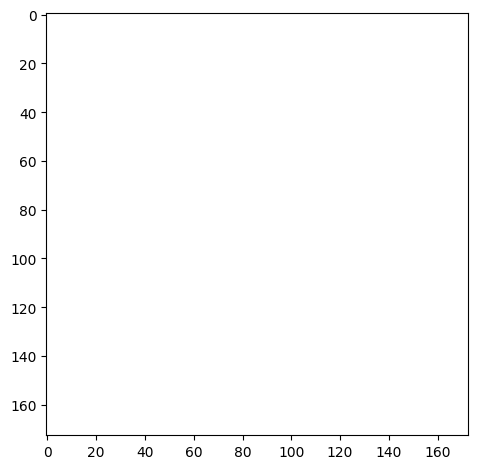

In [4]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata().astype(int)  # Class labels should not be handled as float64

nib.aff2axcodes(data.affine)

fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(ct.shape[2]):  # Axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5)
    # plt.axis("off")
    camera.snap()  # Store the current slice
plt.tight_layout()
animation = camera.animate()  # Create the animation

HTML(animation.to_html5_video())

In [5]:
import torch
class DoubleConv(torch.nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv3d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv3d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())

    def forward(self, X):
        return self.step(X)

class UNet(torch.nn.Module):

    def __init__(self):

        super().__init__()


        ############# DOWN #####################
        self.layer1 = DoubleConv(1, 32)
        self.layer2 = DoubleConv(32, 64)
        self.layer3 = DoubleConv(64, 128)
        self.layer4 = DoubleConv(128, 256)

        #########################################

        ############## UP #######################
        self.layer5 = DoubleConv(256 + 128, 128)
        self.layer6 = DoubleConv(128+64, 64)
        self.layer7 = DoubleConv(64+32, 32)
        self.layer8 = torch.nn.Conv3d(32, 3, 1)  # Output: 3 values -> background, liver, tumor
        #########################################

        self.maxpool = torch.nn.MaxPool3d(2)

    def forward(self, x):

        ####### DownConv 1#########
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        ###########################

        ####### DownConv 2#########
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        ###########################

        ####### DownConv 3#########
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        ###########################

        ##### Intermediate Layer ##
        x4 = self.layer4(x3m)
        ###########################

        ####### UpCONV 1#########
        x5 = torch.nn.Upsample(scale_factor=2, mode="trilinear")(x4)  # Upsample with a factor of 2
        x5 = torch.cat([x5, x3], dim=1)  # Skip-Connection
        x5 = self.layer5(x5)
        ###########################

        ####### UpCONV 2#########
        x6 = torch.nn.Upsample(scale_factor=2, mode="trilinear")(x5)
        x6 = torch.cat([x6, x2], dim=1)  # Skip-Connection
        x6 = self.layer6(x6)
        ###########################

        ####### UpCONV 3#########
        x7 = torch.nn.Upsample(scale_factor=2, mode="trilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        ###########################

        ####### Predicted segmentation#########
        ret = self.layer8(x7)
        return ret


model = UNet()

random_input = torch.randn(1, 1, 128, 128, 128)

with torch.no_grad():
    output = model(random_input)
assert output.shape == torch.Size([1, 3, 128, 128, 128])

In [6]:
from pathlib import Path
import json
import torchio as tio
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np

def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

path = Path("/content/drive/MyDrive/LITS/imagesTr")
subjects_paths = list(path.glob("liver_*"))
subjects = []

for subject_path in subjects_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"CT":tio.ScalarImage(subject_path), "Label":tio.LabelMap(label_path)})
    subjects.append(subject)

for subject in subjects:
    assert subject["CT"].orientation == ("R", "A", "S")

In [7]:
process = tio.Compose([
            tio.CropOrPad((256, 256, 200)),
            tio.RescaleIntensity((-1, 1))
            ])


augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))


val_transform = process
train_transform = tio.Compose([process, augmentation])

train_dataset = tio.SubjectsDataset(subjects[:105], transform=train_transform)
val_dataset = tio.SubjectsDataset(subjects[105:], transform=val_transform)

sampler = tio.data.LabelSampler(patch_size=96, label_name="Label", label_probabilities={0:0.2, 1:0.3, 2:0.5})

train_patches_queue = tio.Queue(
     train_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )

val_patches_queue = tio.Queue(
     val_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )

In [8]:
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_patches_queue, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_patches_queue, batch_size=batch_size, num_workers=0)


class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.loss_history = {'train': [], 'val': []}

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        # Extract the tensor directly from the TorchIO Subject
        img = batch["CT"][tio.DATA]  # Use the defined constant tio.DATA
        mask = batch["Label"][tio.DATA][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()

        pred = self(img)
        loss = self.loss_fn(pred, mask)
        self.loss_history['train'].append(loss.item())
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss

    def validation_step(self, batch, batch_idx):
        # Extract the tensor directly from the TorchIO Subject
        img = batch["CT"][tio.DATA]  # Use the defined constant tio.DATA
        mask = batch["Label"][tio.DATA][:,0]
        mask = mask.long()

        pred = self(img)
        loss = self.loss_fn(pred, mask)
        self.loss_history['val'].append(loss.item())
        self.log("Val Loss", loss)
        self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")
        return loss

    def on_train_epoch_end(self):
        # Save loss history to JSON file at the end of training epoch
        with open('/content/drive/MyDrive/train_history.json', 'w') as f:
            json.dump(self.loss_history, f)

    def on_validation_epoch_end(self):
        # Save loss history to JSON file at the end of validation epoch
        with open('/content/drive/MyDrive/val_history.json', 'w') as f:
            json.dump(self.loss_history, f)

    def log_images(self, img, pred, mask, name):

        results = []
        pred = torch.argmax(pred, 1) # Take the output with the highest value
        axial_slice = 50  # Always plot slice 50 of the 96 slices

        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][:,:,axial_slice]==0, mask[0][:,:,axial_slice])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")

        axis[1].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][:,:,axial_slice]==0, pred[0][:,:,axial_slice])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)



    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]

# Instanciate the model
model = Segmenter()

In [9]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=1,
    mode='min')
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir="/content/drive/MyDrive/logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=30)

# Train the model.
# This might take some hours depending on your GPU
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


RuntimeError: DataLoader worker (pid 13118) is killed by signal: Killed. 

In [ ]:
from IPython.display import HTML
from celluloid import Camera
model = Segmenter.load_from_checkpoint("/kaggle/input/weight/epoch70-step9372.ckpt")
model = model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

"""### Patch Aggregation
The model was trained in a patch wise manner as the full volumes are too large to be placed on a typical GPU.
But we still want to get a result for the whole volume.<br />
torchio helps us doing so by performing *Patch Aggregation*

The goal of patch aggregation is to split the image into patches, then compute the segmentation for each patch and finally merge the predictions into the prediction for the full volume.

The pipeline is as follows:
1. Define the **GridSampler(subject, patch_size, patch_overlap)** responsible for dividing the volume into patches. Each patch is defined by its location accesible via *tio.LOCATION*
2. Define the **GridAggregator(grid_sampler)** which merges the predicted patches back together
3. Compute the prediction on the patches and aggregate them via **aggregator.add_batch(pred, location)**
4. Extract the full prediction via **aggregator.get_output_tensor()**

Additionally, we can leverage the DataLoader from pytorch to perform the prediction in a batch wise manner for a nice speed up
"""

# Select a validation subject and extract the images and segmentation for evaluation
IDX = 4
mask = val_dataset[IDX]["Label"]["data"]
imgs = val_dataset[IDX]["CT"]["data"]

# GridSampler
grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8, 8, 8))

# GridAggregator
aggregator = tio.inference.GridAggregator(grid_sampler)

# DataLoader for speed up
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)

# Prediction
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch['CT']["data"].to(device)  # Get batch of patches
        locations = patches_batch[tio.LOCATION]  # Get locations of patches
        pred = model(input_tensor)  # Compute prediction
        aggregator.add_batch(pred, locations)  # Combine predictions to volume

# Extract the volume prediction
output_tensor = aggregator.get_output_tensor()

"""Finally we can visualize the prediction as usual"""

fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[3], 2):  # axial view
    plt.imshow(imgs[0,:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(pred[:,:,i]==0, pred[:,:,i])
    label_mask = np.ma.masked_where(mask[0,:,:,i]==0, mask[0,:,:,i])
    plt.imshow(mask_, alpha=0.1, cmap="autumn")
    #plt.imshow(label_mask, alpha=0.5, cmap="jet")  # Uncomment if you want to see the label

    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

HTML(animation.to_html5_video())  # convert the animation to a video


In [ ]:
import torchmetrics

# Convert prediction and ground truth masks to numpy arrays
pred_np = pred.cpu().numpy()
mask_np = mask[0].cpu().numpy()

# Flatten the arrays
pred_flat = pred_np.flatten()
mask_flat = mask_np.flatten()

# Compute True Positive, False Positive, and False Negative
tp = (pred_flat * mask_flat).sum()
fp = pred_flat.sum() - tp
fn = mask_flat.sum() - tp

# Compute Dice score
dice_score = 2 * tp / (2 * tp + fp + fn)

print("Dice score:", dice_score)